In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

## 1. Load Data
Loading the preprocessed dataset.

In [10]:
df = pd.read_csv('../datasets/ecb_eurczk_monthly.csv', parse_dates=['timestamp'], index_col='timestamp')
print(df.head())
print(df.info())
print(df.describe())

            eur_czk
timestamp          
1993-12-01   33.455
1994-01-01   33.579
1994-02-01   33.623
1994-03-01   33.612
1994-04-01   33.776
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385 entries, 1993-12-01 to 2025-12-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   eur_czk  385 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB
None
          eur_czk
count  385.000000
mean    28.904366
std      4.179401
min     23.490000
25%     25.485000
50%     27.210000
75%     33.102000
max     38.527000


## 2. Time Series Plot
Visualizing the time series allows us to identify:
- **Trend**: The long-term progression of the series.
- **Seasonality**: Repeating patterns or cycles over time.
- **Outliers**: Unusual data points.
- **Structural Breaks**: Sudden changes in the trend or mean.

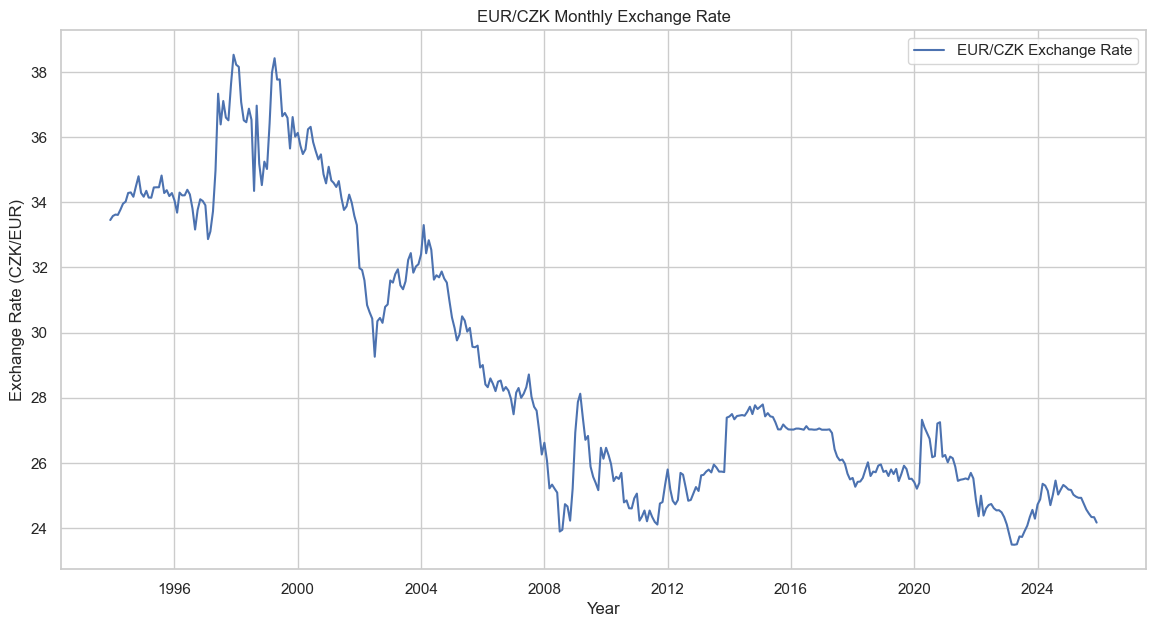

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['eur_czk'], label='EUR/CZK Exchange Rate')
plt.title('EUR/CZK Monthly Exchange Rate')
plt.xlabel('Year')
plt.ylabel('Exchange Rate (CZK/EUR)')
plt.legend()
plt.show()

## 3. Decomposition
Time series decomposition involves separating the time series into three distinct components:
- **Trend**: The underlying direction of the data.
- **Seasonality**: The recurring short-term cycle in the data.
- **Residual (Noise)**: The random variation left after extracting the trend and seasonality.

Since this is **monthly data**, we use a period of **12**.

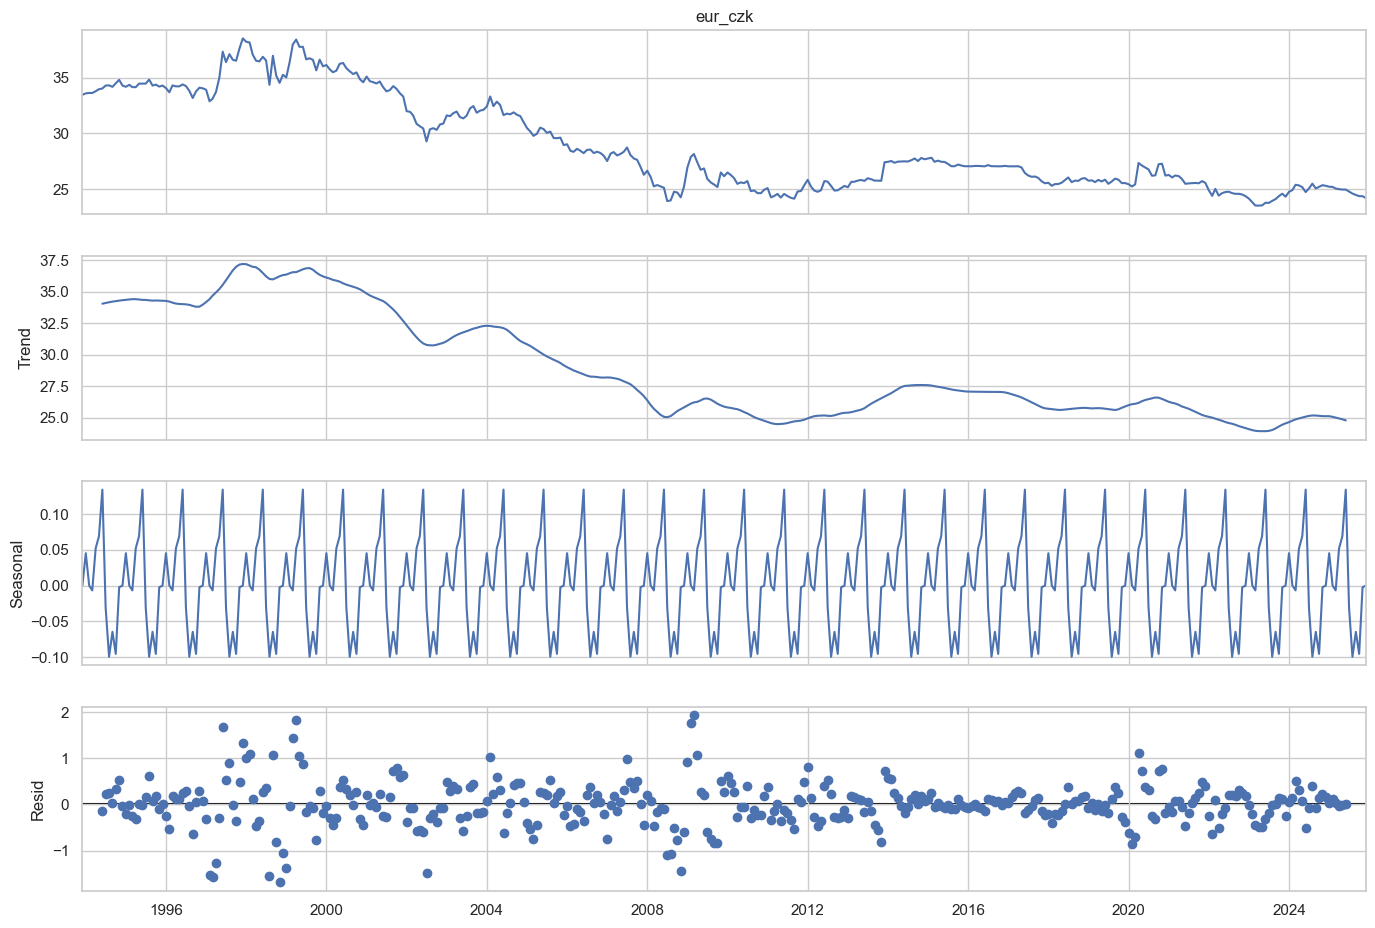

In [12]:
# Decompose the time series
# period=12 for monthly data
decomposition = seasonal_decompose(df['eur_czk'], model='additive', period=12)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

## 4. Autocorrelation Analysis (ACF & PACF)
- **ACF (Autocorrelation Function)**: Measures the correlation between the series and its lagged values. Helps identify MA (Moving Average) terms.
- **PACF (Partial Autocorrelation Function)**: Measures the correlation between the series and its lagged values, controlling for the values of the time series at all shorter lags. Helps identify AR (AutoRegressive) terms.

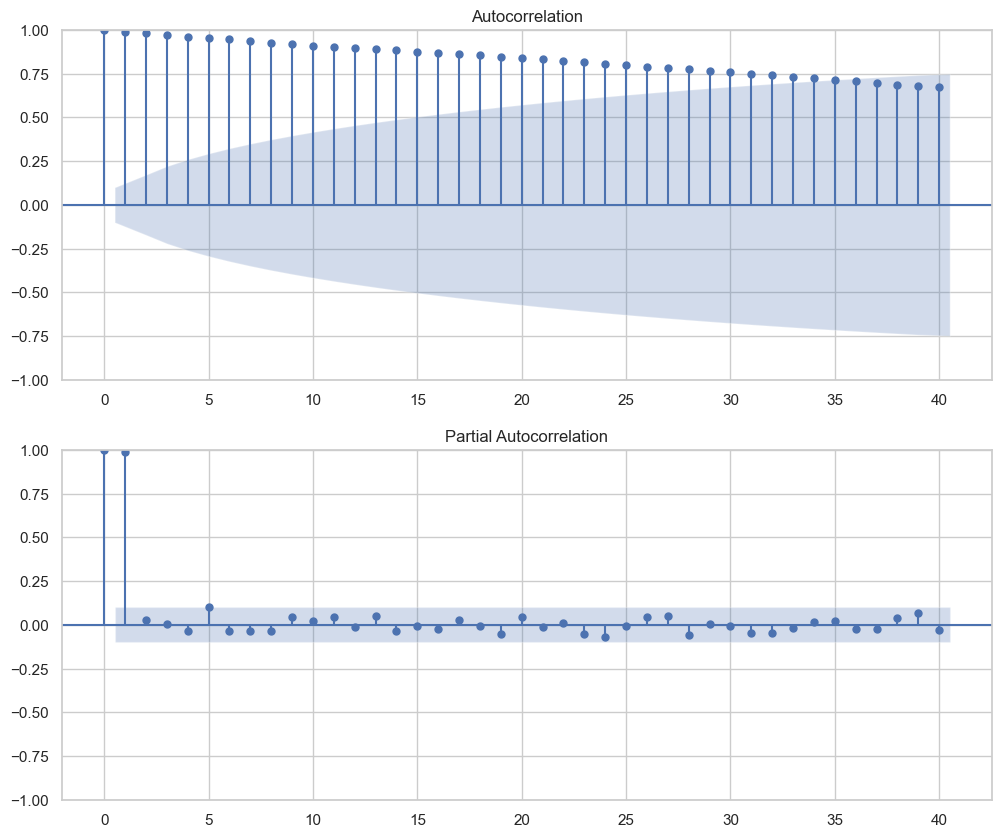

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df['eur_czk'], ax=ax[0], lags=40)
plot_pacf(df['eur_czk'], ax=ax[1], lags=40, method='ywm')
plt.show()

## 5. Distribution of Data
Analyzing the distribution of the data helps us understand:
- **Normality**: Whether the data follows a Gaussian distribution.
- **Skewness**: Asymmetry of the distribution.
- **Kurtosis**: The "tailedness" of the distribution.

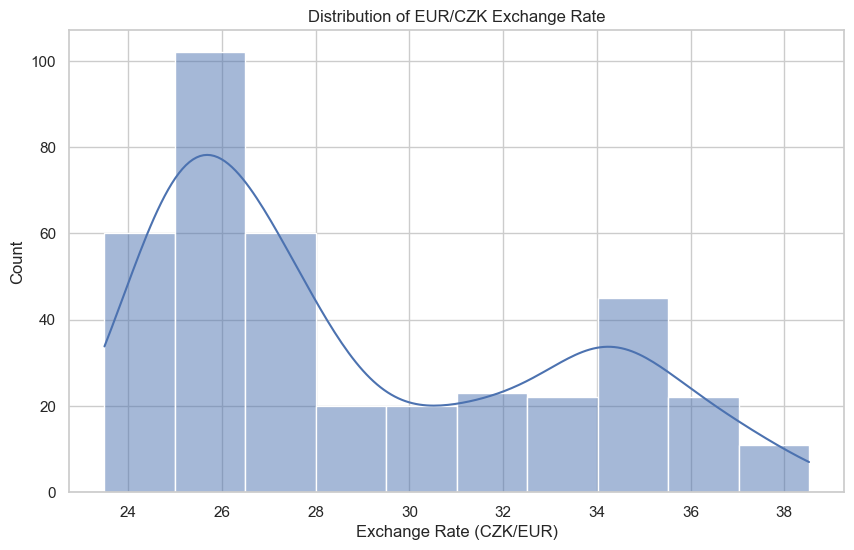

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['eur_czk'], kde=True)
plt.title('Distribution of EUR/CZK Exchange Rate')
plt.xlabel('Exchange Rate (CZK/EUR)')
plt.show()

## 6. Stationarity Check (ADF Test)
Stationarity is a key assumption for many time series models (like ARIMA). A stationary time series has constant mean, variance, and covariance over time.

We use the **Augmented Dickey-Fuller (ADF) Test**:
- **Null Hypothesis ($H_0$)**: The series has a unit root (is non-stationary).
- **Alternative Hypothesis ($H_1$)**: The series has no unit root (is stationary).
- **Interpretation**: If p-value < 0.05, we reject $H_0$ and conclude the series is stationary.

In [15]:
result = adfuller(df['eur_czk'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] < 0.05:
    print("Reject the null hypothesis. Data is stationary.")
else:
    print("Fail to reject the null hypothesis. Data is non-stationary.")

ADF Statistic: -0.9874463702041664
p-value: 0.7578153678465422
Critical Values:
	1%: -3.4476763783532585
	5%: -2.869176103659426
	10%: -2.570837873961219
Fail to reject the null hypothesis. Data is non-stationary.


## 7. Differencing
If the time series is non-stationary (as indicated by the ADF test), we apply **differencing** to stabilize the mean and remove stochastic trends.
- **First Difference**: $y'_t = y_t - y_{t-1}$.

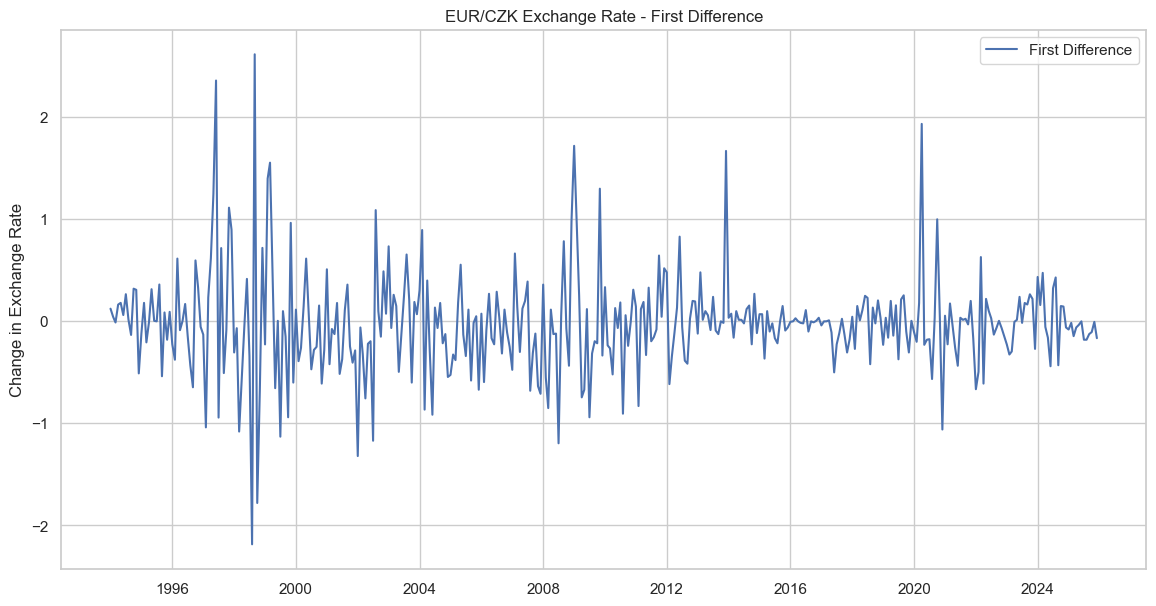

ADF Statistic (Diff): -11.226412218950438
p-value (Diff): 1.955570334359425e-20


In [16]:
df['eur_czk_diff'] = df['eur_czk'].diff()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['eur_czk_diff'], label='First Difference')
plt.title('EUR/CZK Exchange Rate - First Difference')
plt.ylabel('Change in Exchange Rate')
plt.legend()
plt.show()

# Check stationarity of differenced data
df_diff = df['eur_czk_diff'].dropna()
result_diff = adfuller(df_diff)
print('ADF Statistic (Diff):', result_diff[0])
print('p-value (Diff):', result_diff[1])